# Dynamic Training with Skipgram
In this notebook we train the predictions model together with skipgram dynamically. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import statsmodels.api as sm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, auc
import os, sys, time
from importlib import reload
%matplotlib inline

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
path = '/nfs/turbo/intmed-bnallamo-turbo/wsliu/Data/NRD/'

In [2]:
path = '/nfs/turbo/umms-awaljee/wsliu/Data/NRD/'

In [3]:
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [4]:
from keras.layers import Input, Embedding, Concatenate, Reshape, BatchNormalization, LSTM, CuDNNLSTM, CuDNNGRU, Lambda
from keras.models import Model
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.initializers import Constant
import keras.backend as K
import tensorflow as tf

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from DL_utils import plot_roc
from keras_addon import AUCCheckPoint
from utils import get_frequency, preprocess

Using TensorFlow backend.


In [5]:
from ccs_tools import dx_multi, pr_multi, core_dtypes_pd

## Data Preparation

In [7]:
n_DX = 29
n_PR = 15
DXs = ['DX'+str(n) for n in range(2, n_DX+2)]
PRs = ['PR'+str(n) for n in range(1, n_PR+1)]

Save a preprocessed dataset, and the np arrays needed. 

In [28]:
all_df = pd.read_csv(path+'cohorts/{}/{}_pred.csv'.format(cohort, cohort), dtype=core_dtypes_pd)

In [30]:
preprocessed = preprocess(all_df, DX_rarecutpoint=10, PR_rarecutpoint=5)

In [19]:
all_df = preprocessed['int_df']

In [20]:
all_df = all_df[['DX1']+DXs+PRs+['KEY_NRD', 'AGE', 'FEMALE', 'HOSP_NRD', 'PAY1', 'LOS', 'HCUP_ED', 'ZIPINC_QRTL', 'readm30']]

In [24]:
mat_train = all_df[['DX1']+DXs+PRs].values
labels_flatten = np.concatenate((mat_train,np.repeat(mat_train,29,axis=1),np.repeat(mat_train,15,axis=1)),axis=1)

In [25]:
#Construct conditions according to labels_flatten
conditions = labels_flatten != 0
# labels = 0 then conditions = 0
conditions = conditions.astype(int)
# same index pair corresponding to 0
# index of x is 0 and index of y is 0
conditions[:,0] = 0
# index of x from 1 to 29 and the index of same y in labels
for i in range(0,29):
    conditions[:,74+30*i] = 0
# index of x from 30 to 44
for i in range(0,15):
    conditions[:, 1800+16*i] = 0
# index where embed input = 0 
nn = mat_train.shape[0]
for i in range(nn):
    for j in range(1,30):
        if mat_train[i,j] == 0:
            for k in range(45):
                conditions[i,45+29*k+j-1] = 0
    for j in range(30,45):
        if mat_train[i,j] == 0:
            for k in range(45):
                conditions[i,1350+15*k+j-30] = 0            

In [38]:
labels_flatten = labels_flatten.astype(np.int32)
conditions = conditions.astype(np.int32)

In [45]:
np.savez(path+'preprocessed/ami/labels_conditions.npz', labels_flatten=labels_flatten, conditions=conditions)

In [27]:
all_df.to_csv(path+'preprocessed/ami/all_df.csv', index=False)

Read preprocessed data.

In [8]:
cohort='ami'
tst_seed=0

In [9]:
all_df = pd.read_csv(path+'preprocessed/{}/all_df.csv'.format(cohort))

labels_conditions = np.load(path+'preprocessed/ami/labels_conditions.npz')

labels_flatten = labels_conditions['labels_flatten']
conditions = labels_conditions['conditions']

In [10]:
tst_key = pd.read_csv(path+'cohorts/{}/tst_key{}.csv'.format(cohort, tst_seed), names = ['KEY_NRD'])
tst_df = all_df.loc[all_df.KEY_NRD.isin(tst_key.KEY_NRD)]
train_df = all_df.loc[~all_df.KEY_NRD.isin(tst_key.KEY_NRD)]

In [69]:
train_df.shape, all_df.shape

((167841, 55), (187055, 54))

In [34]:
labels_flatten_train = labels_flatten[train_df.index, ]
labels_flatten_tst = labels_flatten[tst_df.index, ]

In [37]:
conditions_train = conditions[train_df.index, ]
conditions_tst = conditions[tst_df.index, ]

### Data formating

In [13]:
n_code_cat = all_df[['DX1']+DXs+PRs].values.max() +1
n_hosp_cat = all_df.HOSP_NRD.values.max()+1

In [14]:
age_mean = train_df['AGE'].mean()
age_std = train_df['AGE'].std()
los_mean = train_df['LOS'].mean()
los_std = train_df['LOS'].std()
n_pay1 = int(train_df0['PAY1'].max())+1
n_ed = int(train_df0['HCUP_ED'].max())+1
n_zipinc = int(train_df0['ZIPINC_QRTL'].max())+1

DX1_array_tst = tst_df['DX1'].values
DX_mat_tst = tst_df[DXs].values
PR_mat_tst = tst_df[PRs].values

hosp_array_tst = tst_df['HOSP_NRD'].values
    
demo_mat_tst = tst_df[['AGE', 'FEMALE']].values
demo_mat_tst[:, 0] = (demo_mat_tst[:, 0]-age_mean)/age_std
pay1_mat_tst = to_categorical(tst_df.PAY1.values, num_classes=n_pay1)[:, 1:]
los_array_tst = (tst_df.LOS.values - los_mean)/los_std
ed_mat_tst = to_categorical(tst_df.HCUP_ED.values, num_classes=n_ed)
zipinc_mat_tst = to_categorical(tst_df.ZIPINC_QRTL.values, num_classes=n_zipinc)[:, 1:]
#transfer_mat_tst = to_categorical(tst_df.SAMEDAYEVENT.values)
other_mat_tst = np.concatenate((demo_mat_tst, pay1_mat_tst, los_array_tst.reshape(los_array_tst.shape+(1,)), 
                                ed_mat_tst, zipinc_mat_tst), axis=1)
y_true = tst_df.readm30.astype(int).values

In [13]:
train_df = train_df0.copy()

In [15]:
n_fold = 5

In [16]:
skf = StratifiedKFold(n_splits=n_fold, random_state=24, shuffle=True)

In [17]:
trn_idx, val_idx = next(skf.split(train_df, train_df.HOSP_NRD))

In [18]:
DX1_array_train = train_df['DX1'].values
            
DX1_array_trn = DX1_array_train[trn_idx]
DX1_array_val = DX1_array_train[val_idx]

DX_mat_train = train_df[DXs].values
            
DX_mat_trn = DX_mat_train[trn_idx, ]
DX_mat_val = DX_mat_train[val_idx, ]

PR_mat_train = train_df[PRs].values
            
PR_mat_trn = PR_mat_train[trn_idx, ]
PR_mat_val = PR_mat_train[val_idx, ]

In [19]:
hosp_array_train = train_df['HOSP_NRD'].values
    
hosp_array_trn = hosp_array_train[trn_idx]
hosp_array_val = hosp_array_train[val_idx]

In [20]:
demo_mat_train = train_df[['AGE', 'FEMALE']].values
demo_mat_train[:, 0] = (demo_mat_train[:, 0]-age_mean)/age_std
pay1_mat_train = to_categorical(train_df.PAY1.values, num_classes=n_pay1)[:, 1:]
los_array_train = (train_df.LOS.values - los_mean)/los_std
ed_mat_train = to_categorical(train_df.HCUP_ED.values, num_classes=n_ed)
zipinc_mat_train = to_categorical(train_df.ZIPINC_QRTL.values, num_classes=n_zipinc)[:, 1:]
#transfer_mat_train = to_categorical(train_df.SAMEDAYEVENT.values)
other_mat_train = np.concatenate((demo_mat_train, pay1_mat_train, los_array_train.reshape(los_array_train.shape+(1,)), 
                                ed_mat_train, zipinc_mat_train), axis=1)

other_mat_trn = other_mat_train[trn_idx, ]
other_mat_val = other_mat_train[val_idx, ]

y_train = train_df.readm30.astype(int).values
y_trn = y_train[trn_idx]
y_val = y_train[val_idx]
Y_trn = to_categorical(y_train[trn_idx])
Y_val = to_categorical(y_train[val_idx])

In [21]:
labels_flatten_trn = labels_flatten_train[trn_idx, ]
labels_flatten_val = labels_flatten_train[val_idx, ]
conditions_trn = conditions_train[trn_idx, ]
conditions_val = conditions[val_idx, ]

In [22]:
code_embed_dim = 100
md_width = 128
fc_width = 512
hosp_embed_dim = 1
dropout = 0.3
job_index = 0
batchsize = 512
n_samples=100
lamb = 1.

### Model Building

In [23]:
from setsum_layer import SetSum, MaskedSum, MaskedDense, MaskedPooling, zero_loss, SkipgramRegularization

In [24]:
embed_initializer = 'uniform'

Model building: 
- setsum_nn 
- setsum_lr
- embed_sum
- embed_pool

In [49]:
tf.reset_default_graph()

In [26]:
input_DX1 = Input(shape=(1,))
DX1_embed0 = Embedding(input_dim=n_code_cat, output_dim=code_embed_dim, embeddings_initializer=embed_initializer, 
                      name='DX1_embed')(input_DX1)
DX1_embed = Reshape((code_embed_dim,))(DX1_embed0)

input_DX = Input(shape = (len(DXs),))
DX_embed0 = Embedding(input_dim=n_code_cat, output_dim=code_embed_dim, mask_zero=True, embeddings_initializer=embed_initializer, 
                     name='DX_embed')(input_DX)
DX_embed = MaskedDense(md_width, activation='relu')(DX_embed0)
DX_embed = MaskedSum()(DX_embed0)

input_PR = Input(shape = (len(PRs),))
PR_embed0 = Embedding(input_dim=n_code_cat, output_dim=code_embed_dim, mask_zero=True, embeddings_initializer=embed_initializer, 
                     name='PR_embed')(input_PR)
PR_embed = MaskedDense(md_width, activation='relu')(PR_embed0)
PR_embed = MaskedSum()(PR_embed0)

input_hosp = Input(shape=(1,))
hosp_embed = Embedding(input_dim=n_hosp_cat, output_dim=hosp_embed_dim, input_length=1)(input_hosp)
hosp_embed = Reshape((hosp_embed_dim, ))(hosp_embed)
input_other = Input(shape=(other_mat_train.shape[1], ))

merged = Concatenate(axis=1)([DX1_embed, DX_embed, PR_embed, hosp_embed, input_other])
input_labels_flatten = Input(shape=(2025, ))
input_conditions = Input(shape=(2025, ))
cr =  SkipgramRegularization(n_samples, n_code_cat, lamb)([DX1_embed0, DX_embed0, PR_embed0, input_labels_flatten, 
                                                           input_conditions])

merged = Dense(fc_width, activation='relu')(merged)
merged = Dropout(dropout)(merged)
prediction = Dense(2, activation='softmax', name='prediction')(merged)
model = Model(inputs=[input_DX1, input_DX, input_PR, input_hosp, input_other,input_labels_flatten,input_conditions], 
              outputs=[prediction,cr])

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [27]:
adam = Adam(lr=0.0002)
model.compile(optimizer=adam, loss=[K.binary_crossentropy,zero_loss])

In [28]:
auccheckpoint = AUCCheckPoint(filepath=model_path+'skipgram_temp'+str(job_index)+'.h5', 
                              validation_y=[Y_val, np.random.randn(Y_val.shape[0],1)], 
                                 validation_x=[DX1_array_val, DX_mat_val, PR_mat_val, hosp_array_val, other_mat_val, 
                                               labels_flatten_val, conditions_val], 
                              auc_output_idx=[0])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=K.epsilon())
earlystop = EarlyStopping(monitor='val_loss', patience=20)

In [43]:
class_weight = {0:(Y_trn.shape[0]/sum(Y_trn[:, 0])), 1:(Y_trn.shape[0]/sum(Y_trn[:, 1]))}

In [45]:
hist = model.fit([DX1_array_trn, DX_mat_trn, PR_mat_trn, hosp_array_trn, other_mat_trn, labels_flatten_trn, conditions_trn], 
                 [Y_trn, np.random.randn(Y_trn.shape[0], 1)], batch_size=batchsize, epochs=2, 
                 validation_data=[[DX1_array_val, DX_mat_val, PR_mat_val, hosp_array_val, other_mat_val, labels_flatten_val, 
                                   conditions_val], [Y_val, np.random.randn(Y_val.shape[0],1)]], 
                    callbacks=[auccheckpoint, reduce_lr, earlystop], class_weight=class_weight, verbose=1)

Train on 133832 samples, validate on 34009 samples
Epoch 1/2
133832/133832 [==============================] - 267s 2ms/step - loss: 3.5175 - prediction_loss: 0.3442 - skipgram_regularization_1_loss: 0.0000e+00 - val_loss: 5.6313 - val_prediction_loss: 0.3411 - val_skipgram_regularization_1_loss: 0.0000e+00
AUC_prediction: 0.7133
Mean AUC: 0.7133

Epoch 2/2
133832/133832 [==============================] - 277s 2ms/step - loss: 2.9255 - prediction_loss: 0.3427 - skipgram_regularization_1_loss: 0.0000e+00 - val_loss: 5.5745 - val_prediction_loss: 0.3408 - val_skipgram_regularization_1_loss: 0.0000e+00
AUC_prediction: 0.7134
Mean AUC: 0.7134



In [31]:
plt.plot(hist.history['val_loss'])

NameError: name 'hist' is not defined

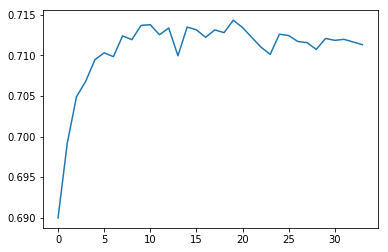

In [40]:
plt.plot(auccheckpoint.auc_history)

In [32]:
model.load_weights(model_path+'skipgram_temp'+str(job_index)+'.h5')

In [38]:
y = model.predict([DX1_array_tst, DX_mat_tst, PR_mat_tst, hosp_array_tst, other_mat_tst, labels_flatten_tst, conditions_tst], 
                  verbose=1)

19214/19214 [==============================] - 24s 1ms/step


In [41]:
y_pred = y[0][:, 1]
#y_true = tst_df.readm30.astype(int).values

{0: 0.7099052404685573}

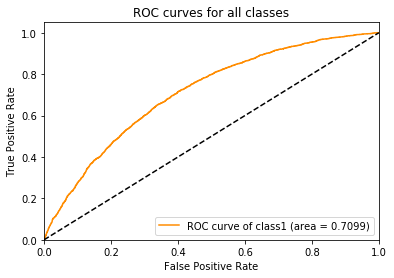

In [42]:
plot_roc(y_pred, y_true)

### backups

In [31]:
DX1_cat = preprocessed['DX1_cat']
DX_cat = preprocessed['DX_cat']
PR_cat = preprocessed['PR_cat']
DX1_dict = preprocessed['DX1_dict']
DX_dict = preprocessed['DX_dict']
PR_dict = preprocessed['PR_dict']
code_cat = preprocessed['code_cat']
hosp_cat = preprocessed['hosp_cat']